## Turning Equations into LaTeX using an attention based seq2seq model
CS230<br>
Adam Jensen, Henrik Marklund<br>
oojensen@stanford.edu, marklund@stanford.edu<br>

This is a joint project with CS229 where we also try a more traditional approach using a multi-stage pipeline.

### 1. Background
We were typing up our CS229 homework and realized that we were spending more time on LaTeX than the actual homework. We did a quick informal survey amongst students in the Huang basement who concurred: yes, typesetting is a major inconvenience! Many said they spent over 5 and 10 hours per homework in CS221 and CS229 respectively. Another typical response was: “I chose not to typeset on the last CS229 homework, as I did not have time”.<br>

There is currently no good solution for converting handwritten notes into LateX. As a consequence, STEM students around the world struggle. The long term goal is to train an algorithm that takes a scan of your a4 page and turns it into latex typesetting. <br>

We limit the scope of this project to:
- Create a seq-to-seq model with attention turning images of digital equations into latex. <br>

This is also a request-for-research at OpenAI: https://openai.com/requests-for-research/#im2latex 


### 2. Dataset
__[Deng et al., 2016](https://arxiv.org/pdf/1609.04938.pdf)__) at Harvard crawled arXiv for mathematical equations and gathered a 100k equations.  This is known as the im2latex-100k dataset.  Each training example is: pixels of a rendered latex equation, matched with ground-truth markup LaTeX.  The images range from 40 x 160 pixels up to much larger sizes.  We filtered out all equations with more than 70 tokens due to memory constraints of our GPU.  After filtering, we had 54,766 training images, 6,032 dev and 6,335 test.


Guilluame Genthial at Stanford was kind enough to send us his generated images (as this takes quite some time). We do some additional processing (padding, and additional downsampling for some of our experiments).

Here is an example image with corresponding latex:


__Latex__:
\widetilde \gamma \_ { \mathrm { h o p f } } \simeq \sum \_ { n > 0 } \widetilde { G } \_ { n } { \frac { ( - a ) ^ { n } } { 2 ^ { 2 n - 1 } } }

##### Histogram: Sequence lengths
<img src="model_visualizations/token_lengths.jpg" height="40%" width="40%" alt="Learning rate schedule" title="Learning rate" />


Further down in the notebook you will see more examples and more details about the dataset.

### 3. Progress through the projeect (sequential):

__1. Dataset loaded and processed.__ <br>
We have approx 70k images with corresponding latex loaded and preprocessed.<br><br>
__2. Encoder-Decoder model up and running in Keras.__ <br><br>
__3. Overfit to 10 examples__<br>
After introducing Batch Normalization we managed to overfit to 10 examples. At this point, still hard to overfit to many more examples.<br><br>
__4. Training with decreasing loss on 40k pairs of (image, sequence)__ <br>
Training is really slow which makes it important that we are systematic and smart about our experiments going forward.
Implemented Clip Gradient and a Learning rate schedule.<br><br>
__5. Created an analogous but less complex problem for debuggin purposes.__ <br>
Since it was hard to know why it was so hard overfitting to a larger number of examples we created a simpler but analogous problem: turning pictures of text into text (but treating each character as a separate token to keep the problem analogous). Training was a lot easier, and we could much more easily overfit on a larger number training examples.<br><br>
__6. Switched to TensorFlow and the Seq2seq library.__ <br><br>
__7. The original Keras model (without attention) is working.__ <br>
Our original mistake was that we did not train the for long enough. By getting the model up on a GPU we could train a lot faster and realize that the model was actually working.<br><br>
__8. Tensorflow model with attention working and improving performance a lot.__ <br>



### 4. The model

#### Overview
Our model is based on a typical seq-to-seq model for translation. We started out with a seq-to-seq model for translation in Keras using LSTM (__[Described by Francois Chollet](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)__. No attention. We replaced the encoder with a convolution neural network as described by in the paper __[Image to Latex by Genthial & Sauvestre (2016)](http://cs231n.stanford.edu/reports/2017/pdfs/815.pdf)__.  We have one model for training and one model for inference (using the weights from the first model).<br><br>

After having tried the model without attention we switched to Tensorflow and used the seq2seq library to implement attention. We used the translation model described __[here](https://github.com/tensorflow/nmt)__ as a sarting point and switched out the encoder to a convolutional neural net.

#### Encoder
We try three different encoder (differing in how many maxpool layers there are). The convolutional network design is one of the architectures found __[here](https://github.com/guillaumegenthial/im2latex/blob/master/model/encoder.py)__. In our best model we use the following encoder:

<img src="model_visualizations/encoder.jpg" height="40%" width="40%" alt="Encoder" title="Encoder (convnet2)" />

#### Decoder
We try two different decoders, one with attention and one without.  

##### Without attention
The model without an attention mechanism is implemented in Keras. It uses the average of the encoding vectors to generate the initial hidden state of the LSTM as described by Genthial & Sauvestre: 
<img src="model_visualizations/decoder_without_attention.jpg" height="40%" width="40%" />


##### With attention
The model  with attention is implemented in Tensorflow using the seq2seq library. Our attention setup is the same as described in Luong et al (2017) with the initial LSTM state being zero vectors (see figure). In the Attention step an importance score is calculated for each encoded vector e based on the current hidden state ht. We use scaled Luong scoring as described in Luong et al (2017). These scores are used to generate a weighted average of the encoded image. This weighted average ēt is called the context vector and is concatenated with ht in order to generate the attention vector at. The attention vector is fed back into the LSTM as well as used to generate the next token via softmax layer. This attention wrapper lets the decoder attend to different parts of the image at each time step. In this model we use an embedding layer with embedding size 80 just like Genthial & Sauvestre.

<img src="model_visualizations/decoder_with_attention.jpg" height="30%" width="30%" />


### 5. Training
We apply forced teaching: we feed in the correct token to the LSTM at each time step.

#### Learning Schedule
We implemented a learning schedule very similar to Genthial’s. It utilizes a warm-up period of three epochs, then after 6 epochs, the rate starts decaying exponentially for 6 epochs. The diagram below is in log10 scale.

<img src="model_visualizations/learning_rate_schedule.jpg" height="40%" width="40%" alt="Learning rate schedule" title="Learning rate" />

#### Other parameters
- Mini-batch size: 16
- Gradient norm clipping: 3
- Optimizer: Adam (beta1 = 0.9, beta2 = 0.999)

#### Train and validation loss
Our cost function is cross entropy loss summed over all the tokens in a decompiled markup sequence. Thus, longer sequences will almost invariably have higher costs. Our best model trained for 12 epochs on a GPU which took 18 hours. Here is training and validation loss over the epochs for our best model:

<img src="model_visualizations/train_and_val_loss.jpg" height="40%" width="40%" alt="Train and validation loss"/>


### 6. Results

#### Experiments
In the table, we show the results on the validation set of a s subset of experiments performed. The attention model is our best model. The values are different from the ones we presented in our final presentation because we 1) reran a few experiments, 2) changed the definition of edit distance, 3) got the attention mechanism to work which significantly improved the results.

| Hyperparameters |                  |            | Results     |                |               |
|-----------------|------------------|------------|-------------|----------------|---------------|
| Encoder         | Decoder          | downsample | Exact Match | Token accuracy | Edit distance (per 10) |
| Convnet1        | No attent.       | 0.6        | 0           | 21.06          | 6.5           |
| Convnet1        | No attent        | 0.9        | 0           | 20.19          | 7.5           |
| Convnet2        | No attent.       | 0.6        | 0           | 18.7 %         | 6.8           |</b>
| <b>Convnet2</b>        | <b>Attention</b>        | <b>None</b>       | <b>17.0%</b>       | <b>47.7</b>           | <b>3.3</b>           |
| Benchmark:       Genthial & Sauvestre (2016)  |            |          | 22%            | N/A           | N/A |

The benchmark Genthial & Sauvestre (2016) is when they use Greedy Search just like us. They boost their performance to 33% when using Beam Search (which we have not implemented yet). To make the results more comparable we used the results they got when using Greedy Search.

- Exact match: How many of the predicted latex sequences match the ground truth latex completely.
- Token accuracy. We check token by token and see how many percent are accurate
- Edit distance: how many edits need to be made per 10 tokens to reach ground truth on average

#### Performance on the test set:
We evaluate our best model on the test set and get the following result:

| Hyperparameters |           |            | Results     |                |               |
|-----------------|-----------|------------|-------------|----------------|---------------|
| Encoder         | Decoder   | downsample | Exact Match | Token accuracy | Edit distance (per 10) |
| Convnet2        | Attention | None       | 17.2%       | 48.4           | 2.9           |


As Genthial & Sauvestre (2016) points out. Using these measures might result in underestimating the performance of the model since 1) the ground truth is not completely normalized, though mostly (there are more than one way to write a sequence.

#### Performance on earlier tokens is better
Here are the metrics from the run in this exact notebook. As you can see, token accuracy and edit distance is better for earlier tokens. We don't include Exact Match here since that obviously will get better since there are fewer tokens to get right.


<b>Standard metrics (all tokens):</b> <br>
Edit distance (per 10 tokens): 2.995950265383056<br>
Token accuracy: 47.771905203487734<br><br>

<b>Metrics on first 15 tokens:</b> <br>
Edit distance (per 10 tokens): 1.784679368855445<br>
Token accuracy: 74.05139230611711<br><br>

<b>Metrics on first 30 tokens:</b> <br>
Edit distance (per 10 tokens): 2.405041660078931<br>
Token accuracy: 60.87257817121338<br><br>

<b>Metrics on first 50 tokens:</b> <br>
Edit distance (per 10 tokens): 2.7318471929116637<br>
Token accuracy: 55.42563315456626<br>

#### Example predictions
These are three example predictions on the validation set. You can see a more example predictions at the end of this notebook.


##### Example 1 (a mix of right and wrong)
<b>Input</b><br>
<img src="model_visualizations/example_input.jpg" height="20%" width="20%" alt="Train and validation loss"/><br><br>

<b>Prediction</b>:<br>
\chi _ { h } ^ { N S } ( q ) = \sum _ { N S } { S } _ { h } ^ { h ^ { \prime } } \chi _ { h } ^ { N S } ( q )<br>
<b>Ground truth</b>:<br>
\chi _ { h } ^ { N S } ( q ) = \sum S _ { h } ^ { h ^ { \prime } } \chi _ { h ^ { \prime } } ^ { N S } ( \tilde { q } )

##### Example 2 (almost correct)
<b>Input</b><br>
<img src="model_visualizations/example_input_2.jpg" height="20%" width="20%" alt="Train and validation loss"/><br>

<b>Prediction</b>:<br>
E ( v ) = \frac { d } { d t } E ( q ) \quad \forall t \, .<br>
<b>Ground truth</b>:<br>
E ( v ) = \frac { d } { d t } E ( q ) \; \; \; \; \; \; \; \forall t \, .

##### Example 3 (perfect prediction)
<b>Input</b><br>
<img src="model_visualizations/example_input_3.jpg" height="20%" width="20%" alt="Train and validation loss"/><br>

<b>Prediction</b>:<br>
( \partial _ { \gamma } , \partial _ { \gamma } ) _ { ( 1 0 ) } = \sqrt { \tilde { \Delta } } e ^ { 2 U }
<b>Ground truth</b>:<br>
( \partial _ { \gamma } , \partial _ { \gamma } ) _ { ( 1 0 ) } = \sqrt { \tilde { \Delta } } e ^ { 2 U }




### 7. Next steps
We want to continue improving this model. These are our next steps:

1. Implement Beam Search
2. Do more hyperparameter search
3. Visualize the Attention.
4. Try implementing a convolutional network as encoder (as Genthial suggested)<br>
A convolutional network would be a lot faster to train. We will try and follow the method proposed in Aneja Deshpande et al (2017)



### 8. References

Chollet, F. (2017, September 29). A ten-minute introduction to sequence-to-sequence learning in Keras [Web log post]. Retrieved December 14, 2017, from https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

Aneja, J., Deshpande, A., & Schwing, A. (2017). Convolutional Image Captioning. arXiv preprint arXiv:1711.09151.

Deng, Y., Kanervisto, A., Ling, J., & Rush, A. M. (2017, July). Image-to-Markup Generation with Coarse-to-Fine Attention. In International Conference on Machine Learning (pp. 980-989).

Genthial, G., & Sauvestre, R. (2016) Image to Latex.

Minh-Thang Luong, Eugene Brevdo & Rui Zhao (2017). Neural Machine Translation (seq2seq) Tutorial. https://github.com/tensorflow/nmt.



# The Code

## Hyperparameters
You can come back to this section later if you want to tweak any hyperparameters

In [37]:
hparams = {}

# Model
hparams['use_attention'] = True
hparams['use_encoding_average_as_initial_state'] = False
hparams['num_units'] = 512  # LSTM number of units
hparams['OVERFIT_TO_SMALL_SAMPLE'] = False
hparams['visualize_attention'] = True

# Training
hparams['num_epochs'] = 16
hparams['mini_batch_size'] = 16
hparams['clip_value'] = 3

# Learning rate config
hparams['warm_up_rate'] = 0.0001
hparams['num_epochs_warm_up'] = 3
hparams['base_learning_rate'] = 0.0004
hparams['num_epochs_constant_lrate'] = 3
hparams['num_decay_epochs'] = 10
hparams['target_rate'] = 0.00001

# Dataset parameters
hparams['max_token_length'] = 70
max_train_examples = 30 # No reason to load a the full training set since we will load a checkpoint
max_val_examples = 100000 # Load all val examples we can
max_test_examples = 100000 # Load all test examples we can

# Other
hparams['MODE'] = "INFERENCE" # TRAINING or INFERENCE
hparams['restore_from_checkpoint'] = False # Relevant for training only. We always restore from checkpoint when doing inferene


ON_FLOYDHUB = True

if ON_FLOYDHUB:
    data = '/data/'
    output = '/output/'
else:
    data = '../data/'
    output = '../output/' 


## Load packages

In [2]:
from matplotlib import pyplot as plt
from tensorflow.python.layers import core as layers_core
import tensorflow as tf
import numpy as np
import datetime
import distance
import json

# Our own file
import train as t

## Load data

The <i>/data</i> folder has the following structure:

```
data
│   test.formulas.norm.txt
│   train.formulas.norm.txt   
│   test.formulas.norm.txt   
│   vocab.txt   
│
└───images_train
│   │   0.png
│   │   1.png
│   │   ...
│   
└───images_test
    │   0.png
    │   1.png
    │   ...
│    
└───images_test
    │   0.png
    │   1.png
    │   ...
```

### Load the vocabulary

In [3]:
token_vocabulary = ["**end**", "**start**", "**unknown**"]

token_vocabulary.extend(t.get_vocabulary("train"))
token_vocab_size = len(token_vocabulary)

target_token_index = dict(
    [(token, i) for i, token in enumerate(token_vocabulary)])
reverse_target_token_index = dict(
    (i, char) for char, i in target_token_index.items())

print("Vocabulary size: ", token_vocab_size)

Vocabulary size:  400


### Load train, val, and test set
Each batch correspond to an image size. We have a total of 19 buckets. This way the model learns to handle different image sizes. But more importantly, this way we can speed up training by not having all images padded to the maximum size in the training set.

Code for loading the data, padding and creating the batches are provided in <i>train.py</i>.

In [4]:
print("\n ======================= Loading Data =======================")


print("\n ======================= Loading train set =======================")
train_dataset = t.get_data_somehow('train', True, hparams['mini_batch_size'], hparams['max_token_length'], max_train_examples , target_token_index)
train_encoder_input_data_batches = train_dataset[0]
train_target_texts_batches = train_dataset[1]
train_sequence_lengths_batches = train_dataset[2]
train_decoder_input_data_batches = train_dataset[3]
train_decoder_target_data_batches = train_dataset[4]
print("\n ======================= Train set loaded =======================")

print("\n ======================= Loading validation set =======================")
val_dataset = t.get_data_somehow('val', True, hparams['mini_batch_size'], hparams['max_token_length'], max_val_examples, target_token_index)
val_encoder_input_data_batches = val_dataset[0]
val_target_texts_batches = val_dataset[1]
val_sequence_lengths_batches = val_dataset[2]
val_decoder_input_data_batches = val_dataset[3]
val_decoder_target_data_batches = val_dataset[4]
print("\n ======================= Validation set loaded =======================")

print("\n ======================= Loading test set =======================")
test_dataset = t.get_data_somehow('test', True, hparams['mini_batch_size'], hparams['max_token_length'], max_test_examples, target_token_index)
test_encoder_input_data_batches = test_dataset[0]
test_target_texts_batches = test_dataset[1]
test_sequence_lengths_batches = test_dataset[2]
test_decoder_input_data_batches = test_dataset[3]
test_decoder_target_data_batches = test_dataset[4]
print("\n ======================= Test set loaded =======================")


print("\n ======================= Data Loaded =======================")


 ======================= Loading Data =======================

 ======================= Loading train set =======================
dumped

 ======================= Train set loaded =======================

 ======================= Loading validation set =======================
Image with id: 3368 was not loaded
dumped

 ======================= Validation set loaded =======================

 ======================= Loading test set =======================
Image with id: 2931 was not loaded
Image with id: 5556 was not loaded
dumped

 ======================= Test set loaded =======================

 ======================= Data Loaded =======================


## Inspect data

In [5]:
num_train_batches = len(train_encoder_input_data_batches)
num_val_batches = len(val_encoder_input_data_batches)
num_test_batches = len(test_encoder_input_data_batches)


num_train_samples = (num_train_batches - 1) * hparams['mini_batch_size'] + train_target_texts_batches[-1].shape[0]
num_val_samples = (num_val_batches - 1) * hparams['mini_batch_size'] + val_target_texts_batches[-1].shape[0]
num_test_samples = (num_test_batches - 1) * hparams['mini_batch_size'] + test_target_texts_batches[-1].shape[0]

print("Num train batches: " + str(num_train_batches))
print("Num val batches: " + str(num_val_batches))
print("Num test batches: " + str(num_test_batches))

print("Num train samples: " + str(num_train_samples))
print("Num val samples: " + str(num_val_samples))
print("Num test samples: " + str(num_test_samples))

Num train batches: 2
Num val batches: 378
Num test batches: 423
Num train samples: 30
Num val samples: 6045
Num test samples: 6757


### Show 10 few examples

Input image


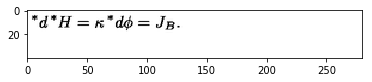

Ground truth
**start** \, ^ { * } d \, ^ { * } H = \kappa \, ^ { * } d \phi = J _ { B } .
Input image


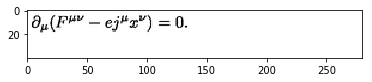

Ground truth
**start** \partial _ { \mu } ( F ^ { \mu \nu } - e j ^ { \mu } x ^ { \nu } ) = 0 .
Input image


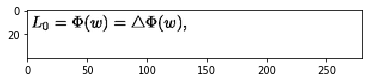

Ground truth
**start** L _ { 0 } = \Phi ( w ) = \bigtriangleup \Phi ( w ) ,
Input image


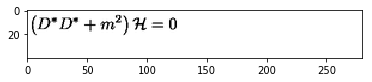

Ground truth
**start** \left( D ^ { * } D ^ { * } + m ^ { 2 } \right) { \cal H } = 0
Input image


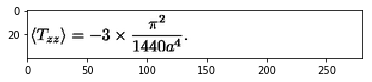

Ground truth
**start** \langle T _ { z z } \rangle = - 3 \times \frac { \pi ^ { 2 } } { 1 4 4 0 a ^ { 4 } } .
Input image


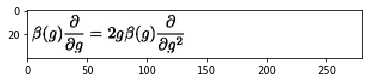

Ground truth
**start** \beta ( g ) \frac { \partial } { \partial g } = 2 g \beta ( g ) \frac { \partial } { \partial g ^ { 2 } }
Input image


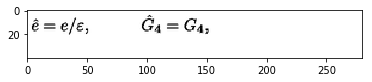

Ground truth
**start** \hat { e } = e / \varepsilon , \ \ \ \ \ \ \ \ \ \hat { G } _ { 4 } = G _ { 4 } ,
Input image


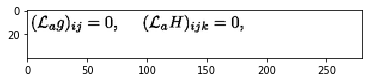

Ground truth
**start** ( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \ \ ( { \cal L } _ { a } H ) _ { i j k } = 0 ,
Input image


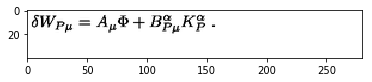

Ground truth
**start** \delta W _ { P \mu } = A _ { \mu } \Phi + B _ { P \mu } ^ { \alpha } K _ { P } ^ { \alpha } \ .
Input image


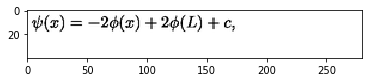

Ground truth
**start** \psi ( x ) = - 2 \phi ( x ) + 2 \phi ( L ) + c ,


In [6]:
for i in range(10):
    print("Input image")
    plt.imshow(np.squeeze(train_encoder_input_data_batches[0][i]), cmap='gray')
    plt.show()
    print("Ground truth")
    print(train_target_texts_batches[0][i])

## The model
Here we present the code for our best model with attention. 

Outline:
- <i>create_placholders()</i>
- <i>create_encoder()</i>
- <i>create_decoder(...)</i>
- <i>create_loss_function(...)</i>
- <i>create_gradients(...)</i>
- <i>create_tf_summary(...)</i>
- <i>create_graph(...)</i>

### Create all the placeholders
We use the trick suggested by Genthail and input a uint8 datatype and then cast it to a float.

In [7]:
def create_placeholders():
    ### Placeholder 1: The Image
    img = tf.placeholder(tf.uint8, [None, None, None, 1], name='img')
    img = tf.cast(img, tf.float32) / 255
    
    ### Placeholder 2: Decoder input sequences (ground truth)
    # Purpose: for forced teaching
    decoder_inputs = tf.placeholder(tf.uint16, [None, None], name='decoder_inputs')  # Supposed to be a sequence of numbers corresponding to the different tokens in the sentence
    decoder_inputs = tf.cast(decoder_inputs, tf.int32)
    
    ### Placeholder 3: Sequence lengths
    # Purpose: for creating a mask to multiply the training loss with )
    decoder_lengths = tf.placeholder(tf.uint16, [None])
    decoder_lengths = tf.cast(decoder_lengths, tf.int32)
    
    ### Placeholder 4: Ground truth output sequences
    #Used together with the logits to calculate the training loss
    decoder_outputs = tf.placeholder(tf.uint16, [None, None], name='decoder_outputs')
    decoder_outputs = tf.cast(decoder_outputs, tf.int32)
    
    ### Placeholder 5: The learning rate
    learning_rate = tf.placeholder(tf.float32, shape=[])
    
    return img, decoder_inputs, decoder_lengths, decoder_outputs, learning_rate

### The encoder

In [8]:
def create_encoder(img):
    # One of Genthails's encoder implementations (from paper)
    # http://cs231n.stanford.edu/reports/2017/pdfs/815.pdf

    # Conv + max pooling
    out = tf.layers.conv2d(img, 64, 3, 1, "SAME", activation=tf.nn.relu)
    # Conv + max pooling
    out = tf.layers.conv2d(out, 128, 3, 1, "SAME", activation=tf.nn.relu)

    out = tf.layers.conv2d(out, 256, 3, 1, "SAME", activation=tf.nn.relu)  

    out = tf.layers.conv2d(out, 256, 3, 1, "SAME", activation=tf.nn.relu)  
    out = tf.layers.max_pooling2d(out, (2, 1), (2, 1), "SAME")

    out = tf.layers.conv2d(out, 512, 3, 1, "SAME", activation=tf.nn.relu)  
    out = tf.layers.max_pooling2d(out, (1, 2), (1, 2), "SAME")

    # Conv valid
    out = tf.layers.conv2d(out, 512, 3, 1, "VALID", activation=tf.nn.relu, name="last_conv_layer")

    ## Out is now a H'*W' encoding of the image

    H = tf.shape(out)[1]
    W = tf.shape(out)[2]

    # out = add_timing_signal_nd(out)
    seq = tf.reshape(tensor=out, shape=[-1, H * W, 512])
    
    
    return seq, H, W

In [9]:
def create_encoder_final_state(seq, num_units):
    img_mean = tf.reduce_mean(seq, axis=1)

    W = tf.get_variable("W", shape=[512, num_units])
    b = tf.get_variable("b", shape=[num_units])
    h0 = tf.tanh(tf.matmul(img_mean, W) + b)

    W_ = tf.get_variable("W_", shape=[512, num_units])
    b_ = tf.get_variable("b_", shape=[num_units])
    c0 = tf.tanh(tf.matmul(img_mean, W_) + b_)

    encoder_final_state = tf.contrib.rnn.LSTMStateTuple(c0, h0)
    
    return encoder_final_state

### Create decoder

#### Creeate the decoder cell

In [10]:
def create_decoder_cell(num_units, use_attention, seq):
    decoder_cell = tf.nn.rnn_cell.LSTMCell(
        num_units,
        initializer=tf.orthogonal_initializer,
    )
    
    if use_attention:
        attention_mechanism = tf.contrib.seq2seq.LuongAttention(
            num_units, seq, scale=True) 
        decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
                decoder_cell, attention_mechanism,
                alignment_history=hparams['visualize_attention'],
                attention_layer_size=num_units)
        
    return decoder_cell

#### Creeate the decoder initial state

In [11]:
def create_decoder_initial_state(decoder_cell, batch_size,use_attention,use_encoding_average_as_initial_state, encoder_state=None):
    if use_attention:
        # Decoder cell must be wrapped with the Attention Wrapper already
        ## Set initial state of decoder to zero (possible to use previous state)
        if use_encoding_average_as_initial_state:
            decoder_initial_state = decoder_cell.zero_state(batch_size, tf.float32).clone(cell_state=encoder_state)
        else:
            decoder_initial_state = decoder_cell.zero_state(batch_size, tf.float32)

    else:
        decoder_initial_state = encoder_state
        
    return decoder_initial_state

#### Create the decoder 

In [12]:
def create_decoder(seq, num_units, decoder_inputs, decoder_lengths, decoder_cell, decoder_initial_state):
    # Decoder: adaption of from seq2seq tutorial (https://github.com/tensorflow/nmt)
    
    embedding_size = 80  # We follow Genthail's suggestion of 80 embedding size 80
    
    # Embedding matrix
    embedding_decoder = tf.get_variable(
        "embedding_encoder", [token_vocab_size, embedding_size], tf.float32)  # tf.float32 was default in the NMT tutorial

    # Look up embedding:
    decoder_emb_inp = tf.nn.embedding_lookup(
        embedding_decoder, decoder_inputs)

    # Helper
    helper = tf.contrib.seq2seq.TrainingHelper(
        decoder_emb_inp, decoder_lengths, time_major=False)

    # Projection layer
    projection_layer = layers_core.Dense(token_vocab_size, use_bias=False,
                                         name="output_projection")
    # Decoder
    decoder = tf.contrib.seq2seq.BasicDecoder(
        decoder_cell, helper, decoder_initial_state,
        output_layer=projection_layer)
    
    return decoder, embedding_decoder, projection_layer

#### Create Loss function

In [13]:
def create_loss_function(decoder_outputs, logits, decoder_lengths, batch_size):
    # Loss function
    crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=decoder_outputs, logits=logits)

    # Create the target_weights (the masking)
    max_seq_length = tf.shape(decoder_outputs)[1]
    target_weights = tf.sequence_mask(decoder_lengths, max_seq_length, dtype=logits.dtype)

    train_loss = tf.reduce_sum(crossent * target_weights) / tf.cast(batch_size, tf.float32)

    return train_loss
    

#### Create gradients

In [14]:
def create_gradients(train_loss, max_gradient_norm):
    params = tf.trainable_variables()
    gradients = tf.gradients(train_loss, params)

    clipped_gradients, global_norm = tf.clip_by_global_norm(
        gradients, max_gradient_norm)
    
    return clipped_gradients, global_norm, gradients, params

#### Create tf summary

In [15]:
def create_tf_summary(params, gradients, train_loss, global_norm):
    param_names = [v.name for v in params]
    gradient_names = [g.name for g in gradients]
    gradient_norms = [tf.norm(gradient) for gradient in gradients]
    grads = list(zip(gradients, params))
    for grad, var in grads:
        tf.summary.histogram(var.name + '/gradient', grad)
    for param in params:
        to_summary = tf.summary.histogram(param.name + '/weight', param)
    
    tf.summary.scalar('loss', train_loss)
    tf.summary.scalar('global_norm', global_norm)
    
    merged = tf.summary.merge_all()
    
    return merged, gradient_norms

#### Create graph 
Let us put it all together using previous functions.

In [16]:
def create_graph(token_vocab_size, num_units, use_attention, use_encoding_average_as_initial_state, training):
    
    # adaption from seq2seq tutorial (https://github.com/tensorflow/nmt)
    
    img, decoder_inputs, decoder_lengths, decoder_outputs, learning_rate = create_placeholders()

    batch_size = tf.shape(img)[0]

    # Get encoding
    seq, H, W = create_encoder(img)

    # Create decoder cell
    # Using LMSTMCell instead of BasicCell like in NMT tutorial 
    # Why so we can initialize with orthogonal intializer (like Genthail)
    decoder_cell = create_decoder_cell(num_units, use_attention, seq)

        
    # Create decoder initial state  
    if use_encoding_average_as_initial_state:
        encoder_final_state = create_encoder_final_state(seq, num_units)
        decoder_initial_state = create_decoder_initial_state(decoder_cell, batch_size, use_attention, True, encoder_state=encoder_final_state)
    else:
        decoder_initial_state = create_decoder_initial_state(decoder_cell, batch_size, use_attention, False)
        
    # Create decoder
    decoder, embedding_decoder, projection_layer = create_decoder(seq, num_units, decoder_inputs, decoder_lengths, decoder_cell, decoder_initial_state)

    # Dynamic decoding
    outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder,
                                                      output_time_major=False) 
    logits = outputs.rnn_output


    # Get Loss function
    train_loss = create_loss_function(decoder_outputs, logits, decoder_lengths, batch_size)

    # Gradients
    max_gradient_norm = hparams['clip_value']  # Usually a number between 1 and 5. Set to 5 in the NMT.
    clipped_gradients, global_norm, gradients, params = create_gradients(train_loss, max_gradient_norm)

    # Optimization
    global_step = tf.Variable(0, trainable=False)  ## IMPORTANT
    optimizer = tf.train.AdamOptimizer(learning_rate)
    update_step = optimizer.apply_gradients(
        zip(clipped_gradients, params), global_step=global_step)

    # Creeate tf summary
    merged, gradient_norms = create_tf_summary(params, gradients, train_loss, global_norm)
    
    
    # Return different tensor depending on if we are training or inference mode
    if training:
        return [merged,
                update_step,
                train_loss,
                optimizer,
                global_norm,
                gradient_norms,
                global_step,
                img,
                decoder_lengths,
                decoder_inputs,
                decoder_outputs,
                learning_rate]
    else:
        return embedding_decoder, decoder_cell, decoder_initial_state, projection_layer, img



## Train the model

We provide the training code in this notebook notebook. However, when we trained, we ran train.py. So we suggest that if you want to train the model yourself you should do the following steps:
1. Tune hyperparameters in train.py (or leave as is)
2. Run "bash setup.sh python3 train.py" on a gpu.

Checkpoint files will be saved in output/checkpoints. Later in this notebook we load from a checkpoint.

### Initialize variables (or restore from checkpoint)

In [17]:
def initialize_variables(sess, restore, path):
    
    if restore:
        print('restoring')
        tf_loader = tf.train.Saver(allow_empty=False)
        tf_loader.restore(sess,path)
    else:
        print('reinitializing')
        sess.run(tf.global_variables_initializer())

### Other useful functions when training

In [18]:
def create_hparams_log():
    file = open(output + "hparams.txt","w") 
    file.write(json.dumps(hparams, indent=4))
    file.close()

def create_metric_output_file():

    file = open(output + "metrics.txt","w") 
    file.write("Train loss" + "\t" + "Val loss" + "\t" + "Learning rate" + "\t" + "Global grad norm" + "\n")
    file.close()
    

# Get number of parameters in model
#From https://stackoverflow.com/questions/38160940/how-to-count-total-number-of-trainable-parameters-in-a-tensorflow-model
def get_num_parameters():
    total_parameters = 0
    for variable in tf.trainable_variables():
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value
        total_parameters += variable_parameters
    
    return total_parameters


### Calculating loss over all examples

In [19]:
def get_loss(img, encoder_input_data_batches,
                        decoder_lengths, sequence_lengths_batches,
                        decoder_inputs, decoder_input_data_batches,
                        decoder_outputs, decoder_target_data_batches,
                        train_loss, sess):
    num_batches = len(sequence_lengths_batches)
    avg_loss = 0
    for i in range(num_batches):
        input_data = {img: encoder_input_data_batches[i],
                      decoder_lengths: sequence_lengths_batches[i],
                      decoder_inputs: decoder_input_data_batches[i],
                      decoder_outputs: decoder_target_data_batches[i],
                      }

        output_tensors = [train_loss]
        loss = sess.run(output_tensors,
                        feed_dict=input_data)

        avg_loss = avg_loss + loss[0]

    avg_loss = avg_loss / num_batches
    return avg_loss


### Function for learning rate

In [20]:
def get_learning_rate(global_step, num_train_batches):
    epoch = int(float(global_step) / num_train_batches)

    if hparams['OVERFIT_TO_SMALL_SAMPLE'] == True:
        if epoch < 20:
            lr_rate = 0.0001
        elif epoch < 40:
            lr_rate = 0.0005
        elif epoch < 500:
            decay_rate = 0.00001 / 0.0005
            decay_steps = hparams['num_epochs']
            lr_rate =  0.0005 * decay_rate ** (float((global_step - num_train_batches * 6)) / decay_steps)
        else:
            lr_rate = 0.00001
    else:
        warm_up_rate = hparams['warm_up_rate']
        num_epochs_warm_up = hparams['num_epochs_warm_up']
        base_learning_rate = hparams['base_learning_rate']
        num_epochs_constant_lrate = hparams['num_epochs_constant_lrate']
        num_decay_epochs = hparams['num_decay_epochs']
        target_rate = hparams['target_rate']

        if epoch < num_epochs_warm_up:
            # Warm up
            lr_rate = warm_up_rate
        elif epoch < num_epochs_warm_up + num_epochs_constant_lrate:
            lr_rate = base_learning_rate
        elif epoch < num_epochs_warm_up + num_epochs_constant_lrate + num_decay_epochs:
            # Over 10 epochs decay learning rate from 0.0005 to 0.00001

            decay_rate = target_rate / base_learning_rate
            decay_steps = num_train_batches * num_decay_epochs
            lr_rate = base_learning_rate * decay_rate ** (float((global_step - num_train_batches * num_epochs_warm_up + num_epochs_constant_lrate)) / decay_steps)
        else:
            lr_rate = target_rate

    return lr_rate

### Putting it all together and training

In [21]:
if hparams['MODE'] == "TRAINING":
    # Create two output files: hyperparameters and metrics
    create_hparams_log()
    create_metric_output_file()
    
    #Load hyperparameters
    num_epochs = hparams['num_epochs']
    max_token_length = hparams['max_token_length']
    mini_batch_size = hparams['mini_batch_size']
    use_attention = hparams['use_attention']
    use_encoding_average_as_initial_state = hparams['use_encoding_average_as_initial_state']
    num_units = hparams['num_units']  # LSTM number of units

    tf.reset_default_graph()

    
    # Create graph
    t = create_graph(token_vocab_size, num_units, use_attention, use_encoding_average_as_initial_state, training=True)

    merged, update_step, train_loss, optimizer, global_norm, gradient_norms, \
    global_step, img, decoder_lengths, decoder_inputs, decoder_outputs, learning_rate = t
      

### Create session, initialize variables and create tf.summary.FileWriter

In [22]:
if hparams['MODE'] == "TRAINING":
    sess = tf.Session()
    tf_saver = tf.train.Saver(save_relative_paths=True)
    initialize_variables(sess, restore=hparams['restore_from_checkpoint'], path='/checkpoints/checkpoints/model_8.ckpt')
    train_writer = tf.summary.FileWriter(output + 'summaries/train/', sess.graph)

### The training loop

In [23]:
if hparams['MODE'] == "TRAINING":

    print("Total number of parameters: ", get_num_parameters())
    
    #Get what global step we are at in training already (so that the learning_rate is set correct)
    glob_step = sess.run(global_step)
    
    for epoch in range(num_epochs + 1):
        print("Epoch: ", epoch)
        for i in range(num_train_batches):
            # Calculate running time for batch
            start_time = datetime.datetime.now()

            # Calculate the learning rate for this step.
            lrate = get_learning_rate(glob_step, num_train_batches)
            input_data = {img: train_encoder_input_data_batches[i],
                          decoder_lengths: train_sequence_lengths_batches[i],
                          decoder_inputs: train_decoder_input_data_batches[i],
                          decoder_outputs: train_decoder_target_data_batches[i],
                          learning_rate: lrate
                          }

            if glob_step % 200 == 0:
                output_tensors = [merged, update_step, train_loss, optimizer._lr, global_norm, gradient_norms,
                                  global_step]
                summary, _, loss, lr_rate, global_grad_norm, grad_norms, glob_step = sess.run(output_tensors,
                                                                                              feed_dict=input_data)
                train_writer.add_summary(summary, glob_step)
                
            else:
                output_tensors = [update_step, train_loss, global_norm, global_step, optimizer._lr]

                _, loss, global_grad_norm, glob_step, lr_rate = sess.run(output_tensors,
                                                                         feed_dict=input_data)

            if i == 0:
                print("Loss:", loss)
                print("Global step", glob_step)
                validation_loss = get_loss(img, val_encoder_input_data_batches,
                        decoder_lengths, val_sequence_lengths_batches,
                        decoder_inputs, val_decoder_input_data_batches,
                        decoder_outputs, val_decoder_target_data_batches,
                        train_loss, sess)  

                training_loss = get_loss(img, train_encoder_input_data_batches,
                        decoder_lengths, train_sequence_lengths_batches,
                        decoder_inputs, train_decoder_input_data_batches,
                        decoder_outputs, train_decoder_target_data_batches,
                        train_loss, sess) 

                file = open(output + "metrics.txt","a") 
                lrate_to_file = ('%s' % ('%.8g' % lrate))
                file.write(str(training_loss) + "\t" + str(validation_loss) + "\t" + lrate_to_file + "\t" + str(global_grad_norm)+ "\n")
                file.close()
        # Run the following in terminal to get up tensorboard: tensorboard --logdir=summaries/train
        
        
        save_path = tf_saver.save(sess, output + 'checkpoints/model_'+str(epoch)+'.ckpt')
        print("Model saved in file: %s" % save_path)

# Inference & Evaluation

## Load from checkpoint

In [24]:
tf.reset_default_graph()

embedding_decoder, decoder_cell, decoder_initial_state, projection_layer, img \
= create_graph(token_vocab_size, hparams['num_units'], hparams['use_attention'], hparams['use_encoding_average_as_initial_state'], False)

sess = tf.Session()

# Make sure you specify the path correctly
initialize_variables(sess, restore=True, path='/checkpoints/checkpoints/model_8.ckpt')

INFO:tensorflow:Summary name conv2d/kernel:0/gradient is illegal; using conv2d/kernel_0/gradient instead.
INFO:tensorflow:Summary name conv2d/bias:0/gradient is illegal; using conv2d/bias_0/gradient instead.
INFO:tensorflow:Summary name conv2d_1/kernel:0/gradient is illegal; using conv2d_1/kernel_0/gradient instead.
INFO:tensorflow:Summary name conv2d_1/bias:0/gradient is illegal; using conv2d_1/bias_0/gradient instead.
INFO:tensorflow:Summary name conv2d_2/kernel:0/gradient is illegal; using conv2d_2/kernel_0/gradient instead.
INFO:tensorflow:Summary name conv2d_2/bias:0/gradient is illegal; using conv2d_2/bias_0/gradient instead.
INFO:tensorflow:Summary name conv2d_3/kernel:0/gradient is illegal; using conv2d_3/kernel_0/gradient instead.
INFO:tensorflow:Summary name conv2d_3/bias:0/gradient is illegal; using conv2d_3/bias_0/gradient instead.
INFO:tensorflow:Summary name conv2d_4/kernel:0/gradient is illegal; using conv2d_4/kernel_0/gradient instead.
INFO:tensorflow:Summary name conv2

## Three functions needed for prediction
 - <i>inference_tensor(...)</i><br>
 Returns translations tensor <br>
 - <i>predict_batch(...) </i><br>
 Runs the translations tensor in a sessoin and returns the actual translations<br>
 - <i>get_predictions_and_labels(...) </i><br>
 Predicts on a set of batches and returns the predictions and the ground truth. Making it easy to evaluate.

In [25]:
def inference_tensor(target_token_index,
              inference_batch_size,
              embedding_decoder,
              decoder_cell,
              decoder_initial_state,
              projection_layer,
              maximum_iterations = hparams['max_token_length']):

    tgt_sos_id = target_token_index['**start**']  # 1
    tgt_eos_id = target_token_index['**end**']  # 0

    # Helper
    inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(embedding_decoder,
        tf.fill([inference_batch_size], tgt_sos_id), tgt_eos_id)

    # Decoder
    inference_decoder = tf.contrib.seq2seq.BasicDecoder(
        decoder_cell, inference_helper, decoder_initial_state,
        output_layer=projection_layer)
    
    # Dynamic decoding
    outputs, final_state, _ = tf.contrib.seq2seq.dynamic_decode(
        inference_decoder, maximum_iterations=maximum_iterations)

    translations = outputs.sample_id
    logits = outputs.rnn_output
    return translations, logits

def predict_batch(sess,
                  batch_,
                  target_token_index,
                  embedding_decoder,
                  decoder_cell,
                  decoder_initial_state,
                  projection_layer,
                  img,
                  maximum_iterations=hparams['max_token_length']):

    batch_len = batch_.shape[0]
    translation_t, logits_t = inference_tensor(target_token_index,
              batch_len,
              embedding_decoder,
              decoder_cell,
              decoder_initial_state,
              projection_layer)
    translation, logits = sess.run([translation_t, logits_t], feed_dict={img: batch_})
    return translation,logits

def get_predictions_and_labels(evaluation_images, evaluation_ground_truth):    
    
    predictions = []
    labels = []    

    print("Evaluating " + str(len(evaluation_images)) + " batches in the " + EVALUATION_SET + " set")
    for idx, batch in enumerate(evaluation_images):

        output, logits = predict_batch(sess,
                      batch,
                      target_token_index,
                      embedding_decoder,
                      decoder_cell,
                      decoder_initial_state,
                      projection_layer,
                      img)

        if idx % 20 == 0:
            print("Progress: " + str(idx) + " batches")

        for idy in range(output.shape[0]):
            prediction = get_token_seq(output[idy,:])
            predictions.append(prediction[:-1])
            labels.append(evaluation_ground_truth[idx][idy].split()[1:])
            
            
        # Don't look at the last batch (some bug crept in at the end making it so that all batch_sizes need to be the same)
        if idx == (len(evaluation_images) - 2) :
            break
        
    return predictions, labels

## Choose was dataset to evaluate on

In [26]:
EVALUATION_SET = "VAL"
if EVALUATION_SET == "VAL":
    evaluation_images = val_encoder_input_data_batches
    evaluation_ground_truth = val_target_texts_batches
elif EVALUATION_SET == "TRAIN":
    evaluation_images = train_encoder_input_data_batches
    evaluation_ground_truth = train_target_texts_batches
elif EVALUATION_SET == "TEST":
    evaluation_images = test_encoder_input_data_batches
    evaluation_ground_truth = test_target_texts_batches

## Functions for Metrics.

### Exact match

In [27]:
# We have the option of just checking the first "max_token_check" examples.

def exact_match(labels, predictions, max_token_check=None):
    #"""Compute exact match"""
    match = 0.0
    count = 0.0
    if max_token_check == None:
        max_token_check = 1000
    for idx in range(len(labels)):
        if np.all(labels[idx][:max_token_check] == predictions[idx][:max_token_check]):
            match += 1

        count += 1
    return 100 * match / count

### Token Accuracy

In [28]:
def token_accuracy(labels, predictions, max_token_check=None):
    #"""Compute accuracy on per word basis."""
    total_acc, total_count = 0., 0.
    if max_token_check==None:
        m_length = 1000
    else:
        m_length = max_token_check

    for idx, target_sentence in enumerate(labels):
        prediction = predictions[idx]

        match = 0.0

        total_count += 1 
        for pos in range(min(len(target_sentence), len(prediction), m_length)):
            label = target_sentence[pos]
            pred = prediction[pos]
            if label == pred:
                match += 1
        
    
        # We have the option of just checking the first "max_token_check" examples.
        if max_token_check==None:
            total_acc += 100 * match / max(len(target_sentence), len(prediction))
        else:
            total_acc += 100 * match / min(len(target_sentence), len(prediction), m_length)
            
    return total_acc / total_count

### Edit distance

In [34]:
def lev_dist(labels, predictions, max_token_check=None):
    
    # In our report we report this distance * 10. (to get distance per 10 tokens for easier interpretation)
    avg_distance = 0
    count = 0.0
  
    for idx in range(len(labels)):

        # We have the option of just checking the first "max_token_check" examples.
        if max_token_check is not None:
            lev_distance = distance.levenshtein(labels[idx][:max_token_check], predictions[idx][:max_token_check])
            lev_distance = lev_distance / (min(len(labels[idx]), max_token_check))
        else:
            lev_distance = distance.levenshtein(labels[idx], predictions[idx])
            lev_distance = lev_distance / (len(labels[idx]))

        avg_distance = avg_distance + lev_distance
        count += 1

    avg_distance = float(avg_distance) / count
    
    avg_distance = avg_distance * 10
    return avg_distance

### Get all the metrics

In [30]:
def get_metrics(labels, predictions, max_token_check=None):
    exact_match_avg = exact_match(labels, predictions, max_token_check)
    token_accuracy_avg = token_accuracy(labels, predictions, max_token_check)
    edit_distance_avg = lev_dist(labels, predictions, max_token_check)
    return {'Exact Match: ': exact_match_avg, 'Token accuracy': token_accuracy_avg, 'Edit distance (per 10 tokens)': edit_distance_avg }

In [31]:
def get_token_seq(int_sequence):
    
    output = []
    for value in int_sequence:
        output.append(reverse_target_token_index[value])
        if reverse_target_token_index[value] == "**end**":
            break
    return output



### Make the predictions

In [32]:
predictions, labels = get_predictions_and_labels(evaluation_images, evaluation_ground_truth)

Evaluating 378 batches in the VAL set
Progress: 0 batches
Progress: 20 batches
Progress: 40 batches
Progress: 60 batches
Progress: 80 batches
Progress: 100 batches
Progress: 120 batches
Progress: 140 batches
Progress: 160 batches
Progress: 180 batches
Progress: 200 batches
Progress: 220 batches
Progress: 240 batches
Progress: 260 batches
Progress: 280 batches
Progress: 300 batches
Progress: 320 batches
Progress: 340 batches
Progress: 360 batches


### Evaluate the predictions

In [38]:
metrics_standard = get_metrics(labels, predictions)
metrics_f15 = get_metrics(labels, predictions, 15)
metrics_f30 = get_metrics(labels, predictions, 30)
metrics_f50 = get_metrics(labels, predictions, 50)

print("Standard metrics: ")
for key in metrics_standard:
    print(key + ": " + str(metrics_standard[key]))

print("")

print("Metrics on first 15: ")
for key in metrics_f15:
    print(key + ": " + str(metrics_f15[key]))

print("")

print("Metrics on first 30: ")
for key in metrics_f30:
    print(key + ": " + str(metrics_f30[key])) 
    
print("")
          
print("Metrics on first 50: ")
for key in metrics_f50:
    print(key + ": " + str(metrics_f50[key]) )

Standard metrics: 
Edit distance (per 10 tokens): 2.995950265383056
Exact Match: : 17.125331564986737
Token accuracy: 47.771905203487734

Metrics on first 15: 
Edit distance (per 10 tokens): 1.784679368855445
Exact Match: : 44.14787798408488
Token accuracy: 74.05139230611711

Metrics on first 30: 
Edit distance (per 10 tokens): 2.405041660078931
Exact Match: : 23.74005305039788
Token accuracy: 60.87257817121338

Metrics on first 50: 
Edit distance (per 10 tokens): 2.7318471929116637
Exact Match: : 17.77188328912467
Token accuracy: 55.42563315456626


### Example predictions in the val set

EXAMPLE 0
Input image


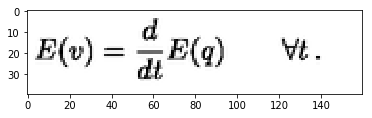

Prediction: 
E ( v ) = \frac { d } { d t } E ( q ) \quad \forall t \, .
Ground truth: 
E ( v ) = \frac { d } { d t } E ( q ) \; \; \; \; \; \; \; \forall t \, .


EXAMPLE 1
Input image


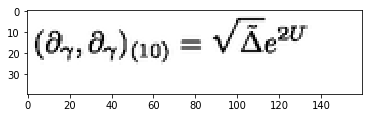

Prediction: 
( \partial _ { \gamma } , \partial _ { \gamma } ) _ { ( 1 0 ) } = \sqrt { \tilde { \Delta } } e ^ { 2 U }
Ground truth: 
( \partial _ { \gamma } , \partial _ { \gamma } ) _ { ( 1 0 ) } = \sqrt { \tilde { \Delta } } e ^ { 2 U }


EXAMPLE 2
Input image


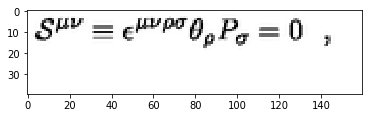

Prediction: 
{ \cal S } ^ { \mu \nu } \equiv \epsilon ^ { \mu \nu \rho \sigma } \theta _ { \rho } P _ { \sigma } = 0 \ \ ,
Ground truth: 
{ \cal S } ^ { \mu \nu } \equiv \epsilon ^ { \mu \nu \rho \sigma } \theta _ { \rho } P _ { \sigma } = 0 \ \ ,


EXAMPLE 3
Input image


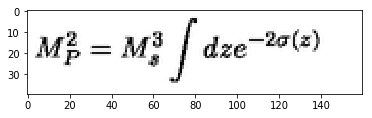

Prediction: 
M _ { P } ^ { 2 } = M _ { P } ^ { 3 } \int d z e ^ { - 2 \sigma ( z ) }
Ground truth: 
M _ { P } ^ { 2 } = M _ { s } ^ { 3 } \int d z e ^ { - 2 \sigma ( z ) }


EXAMPLE 4
Input image


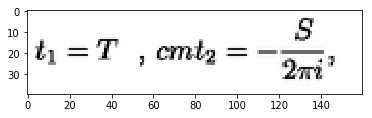

Prediction: 
t _ { 1 } = T ~ ~ , \hspace { 1 c m } t _ { 2 } = T ~ ~ ,
Ground truth: 
t _ { 1 } = T ~ ~ , \hspace { 2 c m } t _ { 2 } = - \frac { S } { 2 \pi i } ,


EXAMPLE 5
Input image


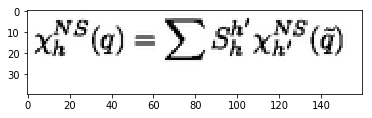

Prediction: 
\chi _ { h } ^ { N S } ( q ) = \sum _ { N S } { S } _ { h } ^ { h ^ { \prime } } \chi _ { h } ^ { N S } ( q )
Ground truth: 
\chi _ { h } ^ { N S } ( q ) = \sum S _ { h } ^ { h ^ { \prime } } \chi _ { h ^ { \prime } } ^ { N S } ( \tilde { q } )


EXAMPLE 6
Input image


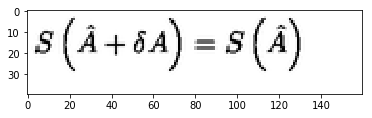

Prediction: 
S \left( \hat { A } + \delta A \right) = S \left( \hat { A } + \delta A \right) = S \left( \hat { A } + \delta A \right)
Ground truth: 
S \left( \hat { A } + \delta A \right) = S \left( \hat { A } \right)


EXAMPLE 7
Input image


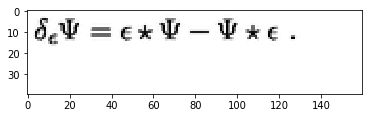

Prediction: 
\delta _ { \epsilon } \Psi = \epsilon \star \, \Psi - \Psi \star \Psi = \epsilon ~ .
Ground truth: 
\delta _ { \epsilon } \Psi = \epsilon \star \Psi - \Psi \star \epsilon \, \, .


EXAMPLE 8
Input image


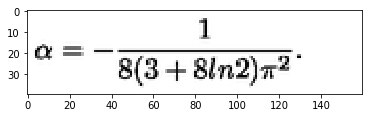

Prediction: 
\alpha = - \frac { 1 } { 8 \operatorname { l n } 2 ) \pi ^ { 2 } } .
Ground truth: 
\alpha = - { \frac { 1 } { 8 ( 3 + 8 \operatorname { l n } 2 ) \pi ^ { 2 } } } .


EXAMPLE 9
Input image


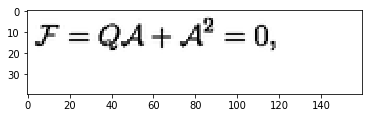

Prediction: 
{ \cal F } = Q { \cal A } + { \cal A } ^ { 2 } = 0 ,
Ground truth: 
{ \cal F } = Q { \cal A } + { \cal A } ^ { 2 } = 0 ,


EXAMPLE 10
Input image


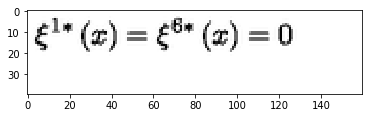

Prediction: 
\xi ^ { 6 * } ( x ) = \xi ^ { 1 * } \left( x \right) = 0
Ground truth: 
\xi ^ { 1 * } \left( x \right) = \xi ^ { 6 * } \left( x \right) = 0


EXAMPLE 11
Input image


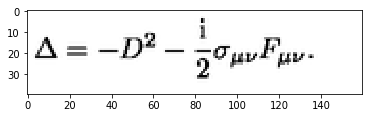

Prediction: 
\Delta = - D ^ { 2 } - \frac { \mathrm { i } } { 2 } \sigma _ { \mu \nu } F _ { \mu \nu } .
Ground truth: 
\Delta = - D ^ { 2 } - \frac { \mathrm { i } } 2 \sigma _ { \mu \nu } F _ { \mu \nu } .


EXAMPLE 12
Input image


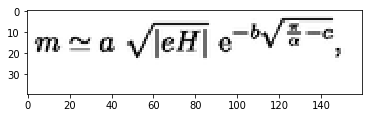

Prediction: 
m \simeq a \ \sqrt { \frac { \pi - c } { \alpha } - c } ,
Ground truth: 
m \simeq a ~ \sqrt { | e H | } ~ \mathrm { e } ^ { - b \sqrt { \frac { \pi } { \alpha } - c } } ,


EXAMPLE 13
Input image


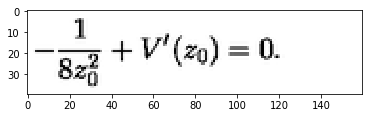

Prediction: 
- \frac { 1 } { 8 z _ { 0 } ^ { 2 } } + V ^ { \prime } ( z _ { 0 } ) = 0 .
Ground truth: 
- \frac { 1 } { 8 z _ { 0 } ^ { 2 } } + V ^ { \prime } ( z _ { 0 } ) = 0 .


EXAMPLE 14
Input image


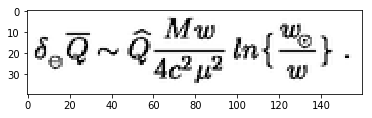

Prediction: 
\delta _ { _ { \scriptsize } } \overline { { Q } } \sim \widehat { Q } \sim \widehat { Q } \mathcal { \frac { w } { 4 c ^ { 2 } \mu ^ { 2 } } } \, \operatorname { l n } \big \{ \frac { w _ { \! _ { \odot } } } { w } \} \
Ground truth: 
\delta _ { _ \ominus } \overline { Q } \sim \widehat Q { \frac { M w } { 4 c ^ { 2 } \mu ^ { 2 } } } \, \operatorname { l n } \big \{ { \frac { w _ { \! _ { \odot } } } { w } } \} \ .




In [49]:
example_range = range(0,40)

for i in example_range:
    batch_num = int(i / hparams['mini_batch_size'])
    example_num_in_batch = int(i % hparams['mini_batch_size'])
    
    print("EXAMPLE " + str(i))
    print("Input image")
    plt.imshow(np.squeeze(evaluation_images[batch_num][example_num_in_batch]), cmap='gray')
    plt.show()
    
    print("Prediction: ")
    print(*predictions[i])
    
    print("Ground truth: ")
    print(*labels[i])
    
    print("")
    print("")